In [1]:
import numpy as np
import matplotlib.pyplot as plt
from labellines import labelLine, labelLines
from simple_tritium_transport_model import Model, ureg, quantity_to_activity


In [2]:
def background_sub(measured, background):
    if measured > background:
        return measured - background
    else:
        return 0 * ureg.Bq

In [3]:
# first sample
background_1 = 0.6212 * ureg.Bq
vial_311 = background_sub(8.2545 * ureg.Bq, background_1)
vial_312 = background_sub(0.8894 * ureg.Bq, background_1)
vial_313 = background_sub(7.4028 * ureg.Bq, background_1)
vial_314 = background_sub(1.0779 * ureg.Bq, background_1)


# first sample
background_2 = 0.28 * ureg.Bq
vial_321 = background_sub(0.230 * ureg.Bq, background_2)
vial_322 = background_sub(0.287 * ureg.Bq, background_2)
vial_323 = background_sub(6.910 * ureg.Bq, background_2)
vial_324 = background_sub(0.596 * ureg.Bq, background_2)


In [4]:
baby_diameter = 1.77 * ureg.inches - 2 * 0.06 * ureg.inches  # from CAD drawings
baby_radius = 0.5 * baby_diameter
baby_volume = 0.1 * ureg.L
baby_cross_section = np.pi * baby_radius**2
baby_height = baby_volume / baby_cross_section
baby_model = Model(
    radius=baby_radius,
    height=baby_height,
    TBR=6.76e-4 * ureg.particle * ureg.neutron**-1,
)

baby_model.number_days = 2 * ureg.days
baby_model.exposure_time = 12 * ureg.hour
baby_model.neutron_rate = (1.2e8 + 3.96e8) * ureg.neutron * ureg.s**-1
baby_model.dt = 0.4 * ureg.h
baby_model.run(6 * ureg.day)

C:\Users\remidm\AppData\Roaming\Python\Python311\site-packages\scipy\optimize\_minpack_py.py:222: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  x0 = asarray(x0).flatten()
C:\Users\remidm\AppData\Roaming\Python\Python311\site-packages\scipy\optimize\_minpack_py.py:237: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  retval = _minpack._hybrd(func, x0, args, 1, xtol, maxfev,
C:\Users\remidm\AppData\Roaming\Python\Python311\site-packages\scipy\optimize\_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


C:\Users\remidm\AppData\Roaming\Python\Python311\site-packages\scipy\integrate\_quadrature.py:353: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  y = np.asarray(y)
C:\Users\remidm\AppData\Roaming\Python\Python311\site-packages\scipy\integrate\_quadrature.py:357: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  x = np.asarray(x)
C:\Users\remidm\AppData\Roaming\Python\Python311\site-packages\labellines\core.py:148: UserWarning: Tried to label line Line2D(_child0), but could not find a label for it.
  warnings.warn(
C:\Users\remidm\AppData\Roaming\Python\Python311\site-packages\labellines\utils.py:27: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return np.asarray(value, dtype=float)


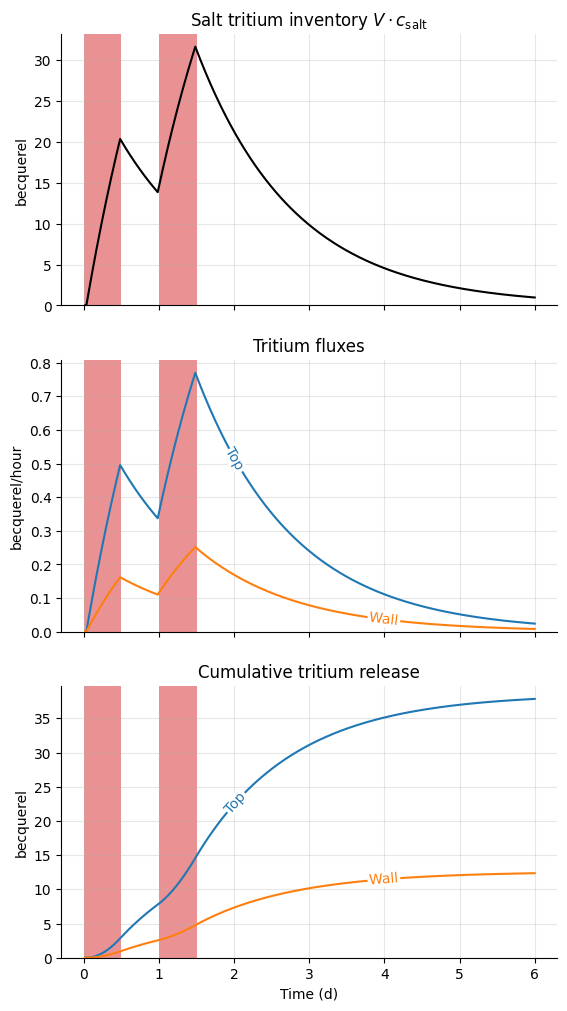

In [5]:
time = baby_model.times.to(ureg.day)

fig, (ax_inv, ax_fluxes, ax_cumul) = plt.subplots(3, 1, sharex=True, figsize=(6.4, 12))
plt.sca(ax_inv)
plt.title("Salt tritium inventory $V \cdot c_\mathrm{salt}$")
plt.plot(
    time,
    quantity_to_activity(baby_model.concentrations * baby_model.volume).to(ureg.Bq),
    color="black",
)

plt.sca(ax_fluxes)
plt.title("Tritium fluxes")
release_top = quantity_to_activity(baby_model.Q_top(baby_model.concentrations)).to(
    ureg.Bq * ureg.s**-1
)
release_top = release_top.to(ureg.Bq * ureg.h**-1)
release_walls = quantity_to_activity(baby_model.Q_wall(baby_model.concentrations)).to(
    ureg.Bq * ureg.s**-1
)
release_walls = release_walls.to(ureg.Bq * ureg.h**-1)
plt.plot(time, release_top, label="Top")
plt.plot(time, release_walls, label="Wall")

plt.sca(ax_cumul)
plt.title("Cumulative tritium release")
integrated_top = quantity_to_activity(baby_model.integrated_release_top()).to(ureg.Bq)
integrated_wall = quantity_to_activity(baby_model.integrated_release_wall()).to(ureg.Bq)

plt.plot(time, integrated_top, label="Top")
plt.plot(time, integrated_wall, label="Wall")
plt.xlabel(f"Time ({time.units:~P})")

for ax in [ax_inv, ax_fluxes, ax_cumul]:
    ax.set_ylim(bottom=0)
    ax.spines[['right', 'top']].set_visible(False)
    ax.grid(alpha=0.3)
    labelLines(ax.get_lines(), zorder=2.5)
    for day in range(baby_model.number_days.to(ureg.day).magnitude):
        ax.axvspan(0*ureg.h + day*ureg.day, baby_model.exposure_time+ day*ureg.day, facecolor='tab:red', alpha=0.5)

plt.savefig("baby_run_3/basic_model_results.svg")
plt.show()


In [6]:
def replace_water(sample_activity, time):
    sample_activity_changed = np.copy(sample_activity)
    times_changed = np.copy(time)

    days_water_change = [
        i + 1 for i in range(baby_model.number_days.to(ureg.day).magnitude + 1)
    ]


    for day in days_water_change[:-1]:
        indices = np.where(times_changed > day * ureg.day)
        # before each irradiation, make the sample activity drop to zero
        sample_activity_changed[indices] -= sample_activity_changed[indices][0]

        # insert nan value to induce a line break in plots
        if indices[0].size > 0:

            first_index = indices[0][0]
            sample_activity_changed = np.insert(sample_activity_changed, first_index, np.nan * ureg.Bq)
            times_changed = np.insert(times_changed, first_index, np.nan * ureg.s)

    return sample_activity_changed, times_changed


In [7]:
COLLECTION_VOLUME = 10 * ureg.ml
LSC_SAMPLE_VOLUME = 10 * ureg.ml


def plot(top=True, walls=True, detection_limit=0.4 * ureg.Bq, irradiation=True, replace_vials=True, title=True, subtitle=True, linelabel=True):

    plt.gca().xaxis.set_units(ureg.day)
    plt.gca().yaxis.set_units(ureg.Bq)

    if title:
        plt.gcf().text(0.08, 0.97, "Sample activity", weight="bold", fontsize=15)
    if subtitle:
        subtitle_text = [
            f"TBR = {baby_model.TBR.to(ureg.dimensionless):.2e~P}, FLiBe volume {baby_model.volume.to(ureg.ml):.0f~P}, neutron rate: {baby_model.neutron_rate:.2e~P}, irradiation time: {baby_model.exposure_time}",
            f"collection volume: {COLLECTION_VOLUME:.0f~P}, sample volume: {LSC_SAMPLE_VOLUME:.0f~P}"
        ]
        plt.gcf().text(0.08, 0.9, s="\n".join(subtitle_text), fontsize=6.5)

    if top:
        sample_activity_top = integrated_top / COLLECTION_VOLUME * LSC_SAMPLE_VOLUME
        times = baby_model.times
        if replace_vials:
            sample_activity_top, times = replace_water(sample_activity_top, baby_model.times)
        plt.plot(
            times.to(ureg.day),
            sample_activity_top,
            label="Top",
        )
    if walls:
        sample_activity_wall = integrated_wall / COLLECTION_VOLUME * LSC_SAMPLE_VOLUME
        times = baby_model.times
        if replace_vials:
            sample_activity_wall, times = replace_water(sample_activity_wall, baby_model.times)
        plt.plot(
            times.to(ureg.day),
            sample_activity_wall,
            label="Walls",
        )

    if detection_limit:
        plt.axhline(y=detection_limit, color="tab:grey", linestyle="dashed")

    if irradiation:
        for day in range(baby_model.number_days.to(ureg.day).magnitude):
            plt.axvspan(
                0 * ureg.h + day * ureg.day,
                baby_model.exposure_time + day * ureg.day,
                facecolor="tab:red",
                alpha=0.5,
            )


    plt.xlim(left=0 * ureg.h)
    plt.ylim(bottom=0)
    # plt.yscale("log")
    if linelabel:
        labelLines(plt.gca().get_lines(), zorder=2.5)
    plt.gca().spines[['right', 'top']].set_visible(False)
    plt.grid(alpha=0.5)


C:\Users\remidm\AppData\Roaming\Python\Python311\site-packages\labellines\core.py:148: UserWarning: Tried to label line Line2D(_child1), but could not find a label for it.
  warnings.warn(


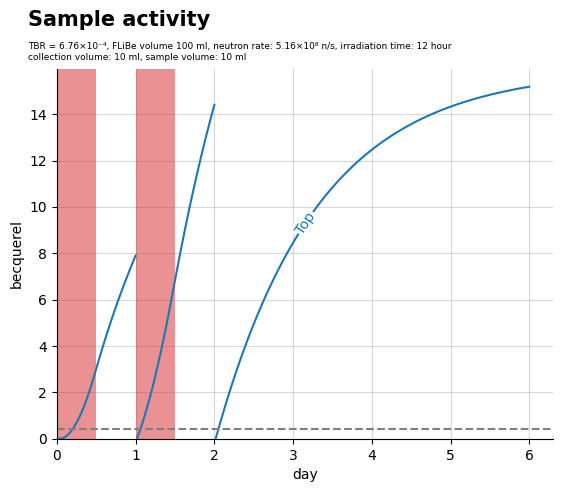

In [8]:
plt.figure()
plot(walls=False)
plt.gca().set_axisbelow(True)
plt.savefig('baby_run_3/results_no_exp.svg')

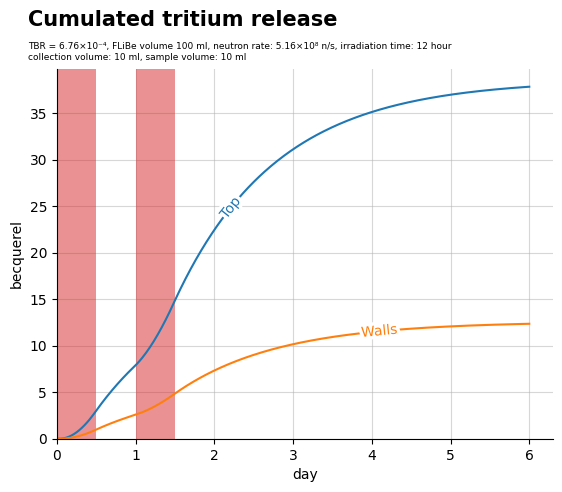

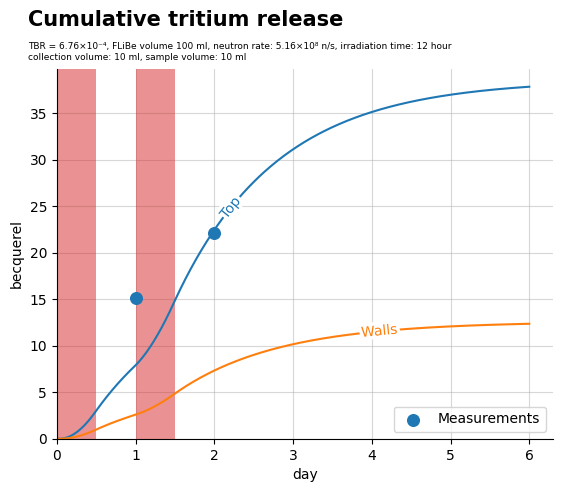

In [9]:
plot(replace_vials=False, title=False, detection_limit=None, linelabel=True)
plt.gcf().text(0.08, 0.97, "Cumulative tritium release", weight="bold", fontsize=15)
plt.gca().set_axisbelow(True)
plt.savefig('baby_run_3/cumulative_tritium_release_no_exp.svg')

plt.figure()
plot(replace_vials=False, title=False, detection_limit=None, linelabel=True)
total_day1 = vial_311 + vial_312 + vial_313 + vial_314
total_day2 = total_day1 + vial_321 + vial_322 + vial_323 + vial_324
s = plt.scatter([1, 2]*ureg.day, [total_day1, total_day2], s=70, label="Measurements")
plt.legend(handles=[s])
plt.gcf().text(0.08, 0.97, "Cumulative tritium release", weight="bold", fontsize=15)
plt.gca().set_axisbelow(True)
plt.savefig('baby_run_3/cumulative_tritium_release.svg')

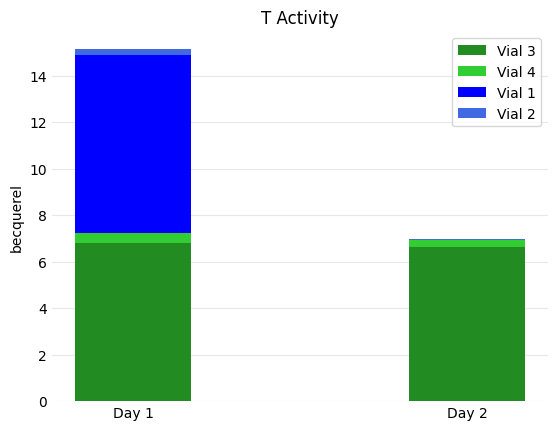

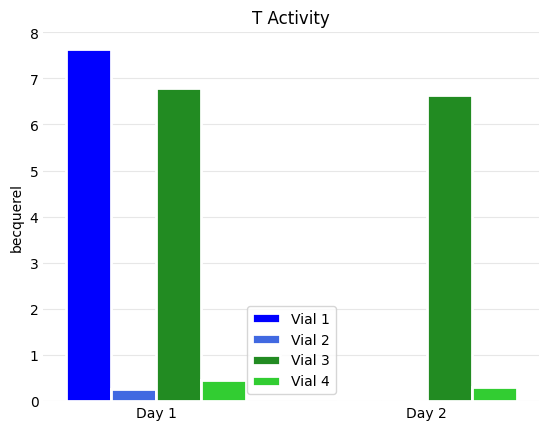

In [10]:
# Create the stacked bar plot
vial_1_vals = np.array([vial_311.magnitude, vial_321.magnitude]) * ureg.Bq
vial_2_vals = np.array([vial_312.magnitude, vial_322.magnitude]) * ureg.Bq
vial_3_vals = np.array([vial_313.magnitude, vial_323.magnitude]) * ureg.Bq
vial_4_vals = np.array([vial_314.magnitude, vial_324.magnitude]) * ureg.Bq

plt.figure()

def plot_bars(index=None, bar_width=0.35, stacked=True):
    if index is None:
        if stacked:
            index = np.arange(2)
        else:
            group_spacing = 1 # Adjust this value to control spacing between groups
            index = np.arange(2) * (group_spacing/2 + 1) * bar_width * 4

    if stacked:
        vial_3_bar = plt.bar(index, vial_3_vals, bar_width, label='Vial 3', color='forestgreen')
        vial_4_bar = plt.bar(index, vial_4_vals, bar_width, label='Vial 4', color='limegreen', bottom=vial_3_vals)
        vial_1_bar = plt.bar(index, vial_1_vals, bar_width, label='Vial 1', color='blue', bottom=vial_3_vals + vial_4_vals)
        vial_2_bar = plt.bar(index, vial_2_vals, bar_width, label='Vial 2', color='royalblue', bottom=vial_3_vals + vial_4_vals + vial_1_vals)
    else:
        vial_1_bar = plt.bar(index - 1.5 * bar_width, vial_1_vals, bar_width, linewidth=2, edgecolor='white', label='Vial 1', color='blue')
        vial_2_bar = plt.bar(index - 0.5 * bar_width, vial_2_vals, bar_width, linewidth=2, edgecolor='white', label='Vial 2', color='royalblue')
        vial_3_bar = plt.bar(index + 0.5 * bar_width, vial_3_vals, bar_width, linewidth=2, edgecolor='white', label='Vial 3', color='forestgreen')
        vial_4_bar = plt.bar(index + 1.5 * bar_width, vial_4_vals, bar_width, linewidth=2, edgecolor='white', label='Vial 4', color='limegreen')
    
    return index

for stacked in [True, False]:
    index = plot_bars(stacked=stacked)
    plt.xticks(index, ['Day 1', 'Day 2'])
    plt.title('T Activity')
    plt.legend()
    plt.gca().spines[['right', 'bottom', 'top', 'left']].set_visible(False)
    plt.grid(True, axis='y', alpha=0.3)
    plt.gca().tick_params(axis=u'both', which=u'both',length=0)
    if stacked:
        plt.savefig('baby_run_3/LSC results_stacked.svg')
    else:
        plt.savefig('baby_run_3/LSC results.svg')
    plt.gca().set_axisbelow(True)
    plt.show()


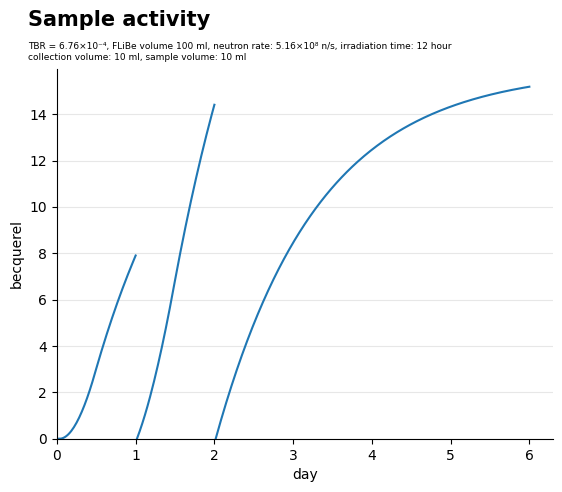

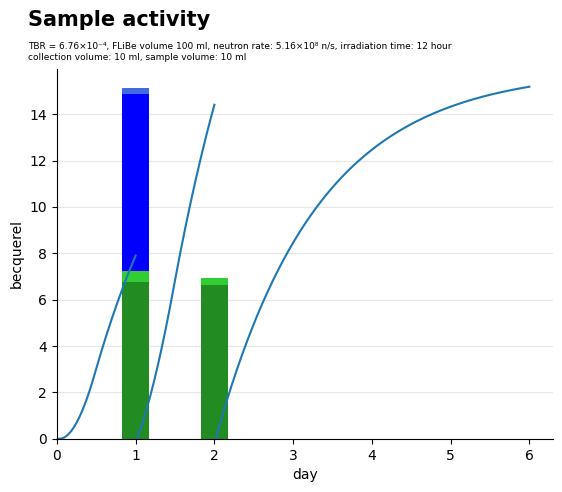

In [11]:
plt.figure()
plot(walls=False, irradiation=False, detection_limit=None, linelabel=False)
plt.grid(False)
plt.grid(True, axis='y', alpha=0.3)
plt.gca().set_axisbelow(True)
plt.savefig('baby_run_3/sample_activity_no_exp.svg')

plt.figure()
plot_bars(index=[1 * ureg.day, 2*ureg.day])
plot(walls=False, irradiation=False, detection_limit=None, linelabel=False)
plt.grid(False)
plt.grid(True, axis='y', alpha=0.3)
plt.gca().set_axisbelow(True)
plt.savefig('baby_run_3/sample_activity.svg')


In [12]:
efficiency1 = vial_311/(vial_311 + vial_312)
efficiency2 = vial_323/(vial_323 + vial_324)
efficiency3 = vial_313/(vial_313 + vial_314)

avg_eff = np.average([efficiency1, efficiency2, efficiency3])
nb_vials = 2
total_eff = 1 - (1-avg_eff)**nb_vials
print(f"Average efficiency per vial {avg_eff:.1%}")
print(f"Total efficiency ({nb_vials} vials): {total_eff:.1%}")

Average efficiency per vial 95.2%
Total efficiency (2 vials): 99.8%


C:\Users\remidm\AppData\Roaming\Python\Python311\site-packages\numpy\lib\function_base.py:509: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  a = np.asanyarray(a)
